In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from prutils import *

def to_csv(name, x, y, z):
    df = pd.DataFrame(z, index=y, columns=x)  # 1st row as the column names
    df.to_csv("experiment-results/"+name, encoding='utf-8', sep=',')


def get_raw_pixels(full_data=True):
    # df = pd.read_csv('data/processed_nist_data.csv', sep=',', header=None)
    if full_data:
        # df = df.as_matrix()
        # X, y = df[:, 1:], df[:, 0]
        # X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, shuffle=True)
        return get_full_data(RAW_PIXELS_DATASET, split_validation=True)
    else:
        # df = df.sample(frac=1).reset_index(drop=True)  # shuffle data
        # df = df.groupby(0)
        # df100 = df.apply(lambda x: x.sample(frac=0.01)).as_matrix()
        # X_train, y_train = df100[:, 1:], df100[:, 0]
        # df1000 = df.apply(lambda x: x.sample(frac=0.1)).as_matrix()
        # X_validate, y_validate = df1000[:, 1:], df1000[:, 0]
                
        X_train, y_train = get_full_data(RAW_PIXELS_DATASET, split_validation=False)
        X_validate, y_validate = get_random_batch(RAW_PIXELS_DATASET, split_validation=False)

    return X_train, X_validate, y_train, y_validate


# def experimentPCA_fulldata(classifier, X_train, X_validate, y_train, y_validate, filename=None, show_results=False, n_comp_auto=False):
#     performance = {}
# 
#     if not n_comp_auto:
#         for n_comp in range(1, 30):
#             print("processing c=", n_comp)
#             pca = PCA(n_components=n_comp)
#             classifier.fit(pca.fit_transform(X_train), y_train)
#             performance[n_comp] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate)))
#         handle_plot(performance, show_results, filename)
#     else:
#         pca = PCA()
#         pca.fit(X_train)
#         variance = pca.explained_variance_
#         n_comp = max(np.argwhere(variance > 0.9))[0]
#         pca.n_components = n_comp
#         classifier.fit(pca.fit_transform(X_train), y_train)
#         performance[0] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate)))
# 
#     return performance, n_comp


def handle_plot(performance, show_results, filename):
    fig = plt.figure()
    plt.title('Number of Components Retained vs Performance')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (%)')

    plt.plot(performance.keys(), performance.values())
    if show_results:
        plt.show()
    if filename:
        pp = PdfPages("experiment-results/" + filename + ".pdf")
        pp.savefig(fig)
        pp.close()
        
        
def get_max_from_dict(x):
    max_key = max(x.keys(), key=(lambda key: x[key]))
    # print(max_key)
    # print(x.get(max_key))
    return max_key, x.get(max_key)

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def plot3d(X, Y, Z, name=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # print(X.shape)
    # print(Y.shape)
    X, Y = np.meshgrid(X, Y)
    # print(Z.shape)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False,
                           vmin=0.4, vmax=1)
    
    # Customize the z axis.
    ax.set_zlim(0.4, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Customize descriptions
    ax.set_xlabel('Hidden layer #1 size')
    ax.set_ylabel('Hidden layer #2 size')
    ax.set_zlabel('Accuracy')
    plt.title("Performance depending on size of hidden layers")

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if name:
        plt.savefig("experiment-results/" + name + ".png", dpi=400)
    plt.show()

In [11]:
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


def tune_layer_size(pca=False, ica= False, kpca=False, full_data=False):
    
    if pca or ica or kpca:
        layer1_step = 10
        layer2_step = 10
        layer1_start = 20
        layer1_stop = 90
        layer2_start = 11
        layer2_stop = 60
    else:
        layer1_step = 20
        layer2_step = 10
        layer1_start = 100
        layer1_stop = 400
        layer2_start = 15
        layer2_stop = 100

    X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data)
    
    results = {}
    res_layer2 = np.arange(layer2_start, layer2_stop, layer2_step)
    res_layer1 = np.arange(layer1_start, layer1_stop, layer1_step)
    res = np.zeros((res_layer2.shape[0], res_layer1.shape[0]))

    layer2_index = 0
    for layer2 in range(layer2_start, layer2_stop, layer2_step):
        # print("progress", (((layer2 - layer2_start) / layer2_step) + 1) / ((layer2_stop - layer2_start) / layer2_step))
        layer1_index = 0
        for layer1 in range(layer1_start, layer1_stop, layer1_step):
            mlp = MLPClassifier(hidden_layer_sizes=(layer1, layer2), max_iter=150, alpha=1e-5,
                                solver='lbfgs', tol=1e-4, random_state=1,
                                learning_rate_init=.1)
            if pca:
                # acc, com = experimentPCA_fulldata(mlp, X_train, X_validate, y_train, y_validate, n_comp_auto=True)
                acc = 1
            elif ica:
                acc = run_ICA_experiment(mlp, RAW_PIXELS_DATASET, max_components = 50, batch=True)
                acc = acc[max(acc, key=acc.get)]/100
            elif kpca:
                acc = run_KPCA_experiment(mlp, RAW_PIXELS_DATASET, max_components = 50, batch=True)
                acc = acc[max(acc, key=acc.get)]/100
            else:
                mlp.fit(X_train, y_train)
                acc = metrics.accuracy_score(y_validate, mlp.predict(X_validate))

            # acc = np.random.rand()/2+0.4

            results[(layer1, layer2)] = acc
            res[layer2_index][layer1_index] = acc

            layer1_index += 1
        layer2_index += 1

    return res_layer1, res_layer2, res, results

In [12]:
def run_full_nn_experiment(name, pca, full_data):
    X, Y, Z, total_results = tune_layer_size(pca=pca, full_data=full_data)
    plot3d(X, Y, Z, name=name)
    to_csv("res_" + name, X, Y, Z)
    print("max:", get_max_from_dict(total_results))
    
    
def run_full_nn_experiment_ica(name, full_data):
    X, Y, Z, total_results = tune_layer_size(pca = False, ica=True, full_data=full_data)
    plot3d(X, Y, Z, name=name)
    to_csv("res_" + name, X, Y, Z)
    print("max:", get_max_from_dict(total_results))
    
    
def run_full_nn_experiment_kpca(name, full_data):
    X, Y, Z, total_results = tune_layer_size(pca = False, ica=False, kpca=True, full_data=full_data)
    plot3d(X, Y, Z, name=name)
    to_csv("res_" + name, X, Y, Z)
    print("max:", get_max_from_dict(total_results))

running nn_opt_layers-full

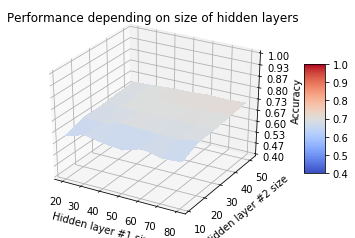

max:

((80, 51), 0.7188500000000001)

omg, the end. total time=

9975.583418607712

In [13]:
import time

start = time.time()

print("running nn_opt_layers-full")
run_full_nn_experiment_ica("nn_opt_layers-full_kpca", full_data=True)


end = time.time()

print("omg, the end. total time=", end-start)